In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
%matplotlib inline

# Tree-Based Methods

In this lecture, we describe tree-based methods for regression and classification. These involve *stratifying* or *segmenting* the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods.

Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches, in terms of prediction accuracy. Hence we also introduce *bagging, random forests,* and *boosting*. Each of these approaches involves producing multiple trees which are then combined to yield a single consensus prediction. We will see that combining a large number of trees can often result in dramatic improvements in prediction accuracy, at the expense of some loss in interpretation.

## Advantages and Disadvantages of Trees

### Advantages

* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
+ Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
+ Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
+ Trees can easily handle qualitative predictors without the need to create dummy variables.

### Disadvantages

* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches.
+ Additionally, trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree.

## Regression Trees

We now discuss the process of building a regression tree. Roughly speaking, there are two steps:

* We divide the predictor space—that is, the set of possible values for $X_1, X_2, . . . , X_p$—into J distinct and non-overlapping regions, $R_1, R_2, . . . , R_J$.
+ For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

For instance, suppose that in Step 1 we obtain two regions, $R_1$ and $R_2$, and that the response mean of the training observations in the first region is 10, while the response mean of the training observations in the second region is 20. Then for a given observation X = x, if $x \in R_1$ we will predict a value of 10, and if $x \in R_2$ we will predict a value of 20.

### Recursive binary splitting
We now elaborate on Step 1 above. How do we construct the regions $R_1, . . . , R_J$? In theory, the regions could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles (hyperrectangles), for simplicity and for ease of interpretation of the resulting predictive model. The goal is to find boxes $R_1, . . . , R_J$ that minimize the RSS, given by:
$$\sum^J_{j=1}\sum_{i\in R_j} (y_i-\hat y_{R_j})^2$$
where $\hat y_{R_j}$ is mean respones of jth hyperrectangles.  

Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into J boxes. For this reason, we take a *top-down, greedy* approach that is known as **recursive binary splitting**. The approach is *top-down* because it begins at the top of the tree (at which point all observations belong to a single region) and then successively splits thepredictor space; each split is indicated via two new branches further down on the tree. It is *greedy* because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In order to perform **recursive binary splitting**, we first select the predictor Xj and the cutpoint s such that splitting the predictor space into the regions $\{X|Xj < s\}$ and $\{X|Xj \geq s\}$ leads to the greatest possible
reduction in RSS. (The notation $\{X|Xj < s\}$ means the *region of predictor space in which $X_j$ takes on a value less than s.*). That is, we consider all predictors $X_1, . . . , X_p$, and all possible values of the cutpoint s for each of
the predictors, and then choose the predictor and cutpoint such that the resulting tree has the lowest RSS. In greater detail, for any j and s, we define the pair of half-planes:
$$R_1(j, s) = \{X|Xj < s\} \text{ and } R_2(j, s) = \{X|Xj \geq s\}$$
and we seek the value of j and s that minimize the equation:
$$\sum_{i: x_i \in R_1(j,s)} (y_i-\hat y_{R_1})^2+\sum_{i: x_i \in R_2(j,s)} (y_i-\hat y_{R_2})^2$$

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions.We now have three regions. Again, we look to split one of these three regions further, so as to minimize the RSS. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

Once the regions $R_1, . . . , R_J$ have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.

### Tree Pruning

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1, . . . , R_J$ ) might lead to lower variance and better interpretation at the cost of a little bias. 

Therefore, a better strategy is to grow a very large tree $T_0$, and then **prune** it back in order to obtain a **subtree**. How do we determine the best way to prune the tree? Intuitively, our goal is to select a subtree that  leads to the lowest test error rate. Given a subtree, we can estimate its test error using cross-validation or the validation set approach. However, estimating the cross-validation error for every possible subtree would be too cumbersome, since there is an extremely large number of possible subtrees. Instead, we need a way to select a small set of subtrees for consideration.

**Cost complexity pruning**—also known as **weakest link pruning**—gives us a way to do just this. Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$
For each value of α there corresponds a subtree $T \subset T_0$ such that:
$$\sum_{m=1}^{|T|}\sum_{x_i\in R_m}(y_i-\hat y_{R_m})^2+\alpha |T|$$
is as small as possible. Here |T| indicates the number of terminal nodes of the tree T. The tuning parameter $\alpha$ controls a trade-off between the subtree’s complexity and its fit to the training data. When $\alpha=0$, then the subtree T will simply equal $T_0$, because then above equation just measures the training error. However, as $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the above equation will tend to be minimized for a smaller subtree.

It turns out that as we increase $\alpha$ from zero, branches get pruned from the tree in a nested and predictable fashion, so obtaining the whole sequence of subtrees as a function of α is easy. We can select a value of $\alpha$ using a validation set or using cross-validation. We then return to the full data set and obtain the subtree corresponding to $\alpha$. This process is summarized in following Algorithm:

![alt text](tree1.png)

Now let's try fitting a **regression tree** to the ${\tt Boston}$ data set from the ${\tt MASS}$ library. First, we create a
training set, and fit the tree to the training data using ${\tt medv}$ (median home value) as our response:

In [2]:
boston_df = pd.read_csv('Boston.csv')
X = boston_df.drop('medv', axis=1)
y = boston_df.medv
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.5, random_state=0)

# Pruning not supported. Choosing max depth 2)
regr2 = DecisionTreeRegressor(max_depth=2)
regr2.fit(X_train, y_train)

/home/hhp468/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Let's take a look at the tree:

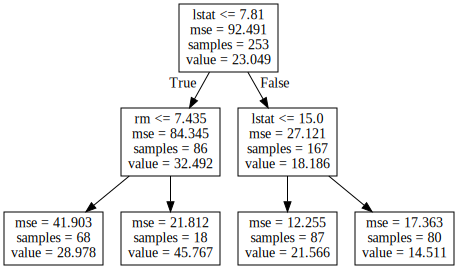

In [3]:
export_graphviz(regr2, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The variable ${\tt lstat}$ measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of ${\tt lstat}$ correspond
to more expensive houses. The tree predicts a median house price
of $\$45,766$ for larger homes (${\tt rm}>=7.435$) in suburbs in which residents have high socioeconomic
status (${\tt lstat}<7.81$).

Now let's see how it does on the test data:

28.80154486445795

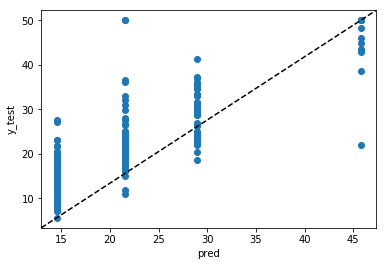

In [4]:
pred = regr2.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

## Classification Trees

The task of growing a classification tree is quite similar to the task of growing a regression tree. Just as in the regression setting, we use recursive binary splitting to grow a classification tree. However, in the classification setting, RSS cannot be used as a criterion for making the binary splits. A natural alternative to RSS is the *classification error rate*. However, it turns out that classification error is not sufficiently sensitive for tree-growing, and in practice two other measures are preferable. Let $\hat p_{mk}$ represents the proportion of training observations in the mth region that are from the kth class.
The **Gini index** is defined by
$$G=\sum^K_{k=1}\hat p_{mk}(1-\hat p_{mk})$$
a measure of total variance across the K classes. It is not hard to see that the Gini index takes on a small value if all of the $\hat p_{mk}$ are close to zero or one. For this reason the Gini index is referred to as a measure of node purity—a small value indicates that a node contains predominantly observations from a single class.
An alternative to the Gini index is entropy, given by
$$D=-\sum^K_{k=1}\hat p_{mk}\log \hat p_{mk}$$
like the Gini index, the entropy will take on a small value if the mth node is pure. In fact, it turns out that the Gini
index and the entropy are quite similar numerically.

When building a classification tree, either the Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate. Any of these three approaches might be used when pruning the tree, but the classification error rate is preferable if prediction accuracy of the final pruned tree is the goal.

Now, We are using **classification trees** to analyze the ${\tt Carseats}$ data set. In these
data, ${\tt Sales}$ is a continuous variable, and so we begin by converting it to a
binary variable. We use the ${\tt ifelse()}$ function to create a variable, called
${\tt High}$, which takes on a value of ${\tt Yes}$ if the ${\tt Sales}$ variable exceeds 8, and
takes on a value of ${\tt No}$ otherwise. We'll append this onto our dataFrame using the ${\tt .map()}$ function, and then do a little data cleaning to tidy things up:

In [5]:
df3 = pd.read_csv('Carseats.csv')
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int64
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int64
US             400 non-null int64
High           400 non-null int64
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [6]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.5, random_state=0)

/home/hhp468/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.955

We now use the ${\tt DecisionTreeClassifier()}$ function to fit a classification tree in order to predict
${\tt High}$ using all variables but ${\tt Sales}$ (that would be a little silly...). Unfortunately, manual pruning is not implemented in ${\tt sklearn}$: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the ${\tt max\_depth}$ parameter:

We see that the training accuracy is 95.5%.

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in ${\tt sklearn}$. We use the ${\tt export\_graphviz()}$ function to export the tree structure to a temporary ${\tt .dot}$ file,
and the ${\tt graphviz.Source()}$ function to display the image:

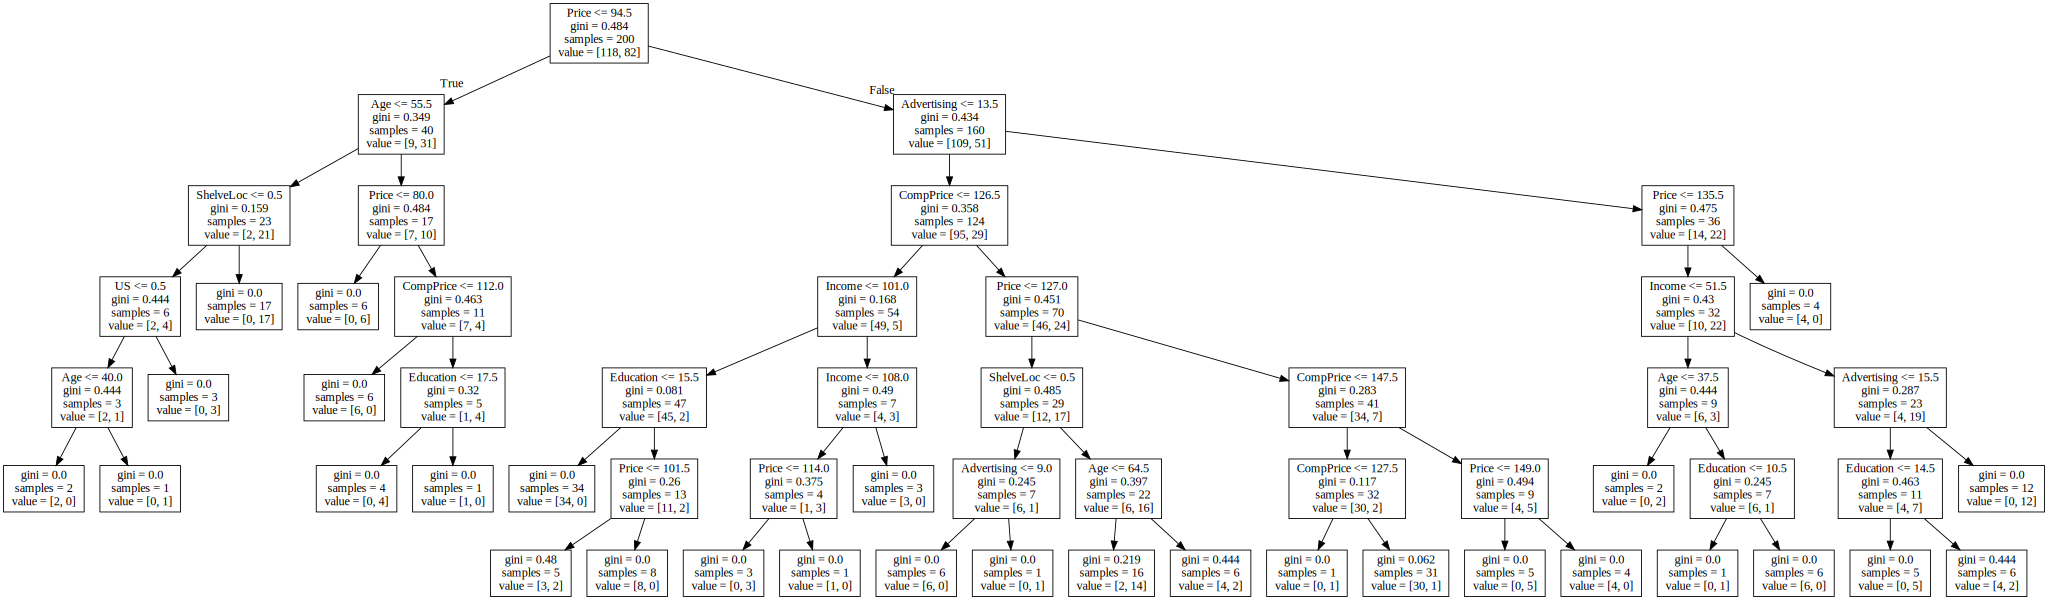

In [8]:
export_graphviz(clf, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The most important indicator of ${\tt High}$ sales appears to be ${\tt Price}$.

In [9]:
pred = clf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)
# 99+50/200 = 0.745

     No  Yes
No   99   32
Yes  19   50


Finally, let's evaluate the tree's performance on
the test data. The ${\tt predict()}$ function can be used for this purpose. We can then build a confusion matrix, which shows that we are making correct predictions for
around 74.5% of the test data set: